In [1]:
from lib.utilities import *
from lib.file_writer import FileWriter
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
fw = FileWriter()
print(fw.save_data_file)

#def save_data_file(self, images, num_trials, num_pts, int_pts, num_fp_pts, width, height,
# rliLow, rliHigh, rliMax, sliceNo, locNo, recNo, program, int_trials)

<bound method FileWriter.save_data_file of <lib.file_writer.FileWriter object at 0x000001F719CDEA00>>


In [3]:
datadir = "./tsm_targets/01-17-22" # All files in this directory + subdirectories are loaded
selected_filename = "Untitled006" # focus for subsequent analysis
file_type = '.tsm'
horizontal_cropping = [250, 750]  # This is the cropping recommended for 1024-px width
t_cropping = [0, -1]  # TSM artifacts
binning = 5

In [4]:
# Load data
processed = [] # to avoid re-processing later
data_loader = DataLoader()
if file_type == '.tsm':
    data_loader.load_all_tsm(data_dir=datadir + "/tsm_targets")

.\tsm_targets/Untitled004.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}
.\tsm_targets/Untitled005.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}
.\tsm_targets/Untitled006.tsm to be treated as TSM file to open
Reading file as 200 images of size 1024 x 320
TBN file designates origin as NI for this data.
Found 4 channels in BNC ratio: 1
{'points_per_trace': 200, 'raw_width': 1024, 'raw_height': 320, 'interval_between_samples': 1.0, 'number_of_trials': 1}


In [5]:
# Select data of interest        
selected_data = data_loader.select_data_by_keyword(selected_filename)

# Increase binning and cropping until PhotoZ can manage the image size
selected_data.clip_data(y_range=horizontal_cropping, t_range=t_cropping)
selected_data.bin_data(binning=binning)

raw_data, meta, rli = selected_data.get_data(), selected_data.get_meta(), selected_data.get_rli()
fp_data = selected_data.fp_data

{'points_per_trace': 199, 'raw_width': 199, 'raw_height': 100, 'interval_between_samples': 1.0, 'number_of_trials': 1} (1, 199, 319, 500)


In [6]:
# Fill in missing metadata
meta['version'] = 5
meta['slice_number'] = 5
meta['location_number'] = 5
meta['record_number'] = 5
meta['camera_program'] = 2

meta['interval_between_trials'] = 1
meta['acquisition_gain'] = 1
meta['time_RecControl'] = 5

meta['reset_onset'] = 1
meta['reset_duration'] = 5
meta['shutter_onset'] = 5
meta['shutter_duration'] = 5

meta['stimulation1_onset'] = 20
meta['stimulation1_duration'] = 1
meta['stimulation2_onset'] = 0
meta['stimulation2_duration'] = 0

meta['acquisition_onset'] = 1
meta['interval_between_samples'] = 5

meta['raw_width'] = raw_data.shape[2]
meta['raw_height'] = raw_data.shape[3]
meta['points_per_trace'] = raw_data.shape[1]
meta['number_of_trials'] = raw_data.shape[0]

rli = {}
rli['rli_low'] = [0] * int(meta['raw_width'] * meta['raw_height'])
rli['rli_high'] = [0] * int(meta['raw_width'] * meta['raw_height'])
rli['rli_max'] = [0] * int(meta['raw_width'] * meta['raw_height'])

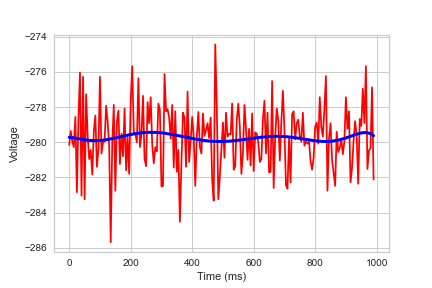

In [7]:
# Run this cell at most once

# Apply baseline correction here. Because PhotoZ chokes on baseline correcting TurboSM data
tr = Tracer()
#data inversing
raw_data = -raw_data

# Need to subtract off the low-frequency voltage drift. First-order correction
tr.correct_background(meta, raw_data)

0


array([[[[2032, 2181, 2050, ..., 2168, 2329, 2312],
         [2263, 2109, 2117, ..., 2300, 2212, 1926],
         [1807, 2079, 2031, ..., 1842, 2394, 1840],
         ...,
         [1978, 2037, 2077, ..., 2211, 2027, 2124],
         [2153, 2047, 2028, ..., 1983, 2043, 2150],
         [2068, 2187, 1958, ..., 2438, 2368, 2075]],

        [[2140, 2108, 1838, ..., 2072, 1874, 1695],
         [2160, 1968, 2010, ..., 2221, 1835, 2104],
         [2186, 2134, 2273, ..., 2504, 2409, 2017],
         ...,
         [2238, 1849, 2060, ..., 2301, 2071, 1954],
         [2036, 1948, 2196, ..., 2228, 1986, 2391],
         [2209, 2104, 1846, ..., 2182, 1829, 2024]],

        [[2062, 1933, 2338, ..., 1710, 2214, 1724],
         [1922, 1726, 1783, ..., 1705, 1801, 1963],
         [2268, 1938, 2008, ..., 1817, 1339, 2171],
         ...,
         [1978, 2144, 2232, ..., 1972, 2125, 1946],
         [2015, 1768, 1788, ..., 1891, 1913, 1754],
         [1859, 1964, 2230, ..., 1731, 1623, 1866]],

        ...,

  

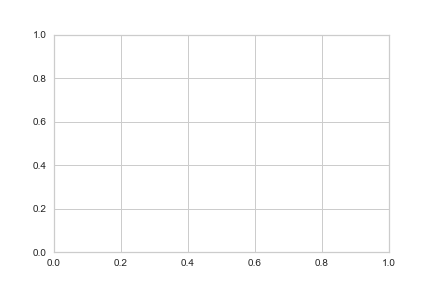

In [8]:
plt.subplots() # finalize plot from previous cell
# normalize raw data to 12-bit range
raw_data -= np.min(raw_data)
raw_data /= np.max(raw_data)
raw_data *= (2 ** 12)

raw_data = raw_data.astype(np.int16)
print(np.min(raw_data))
raw_data

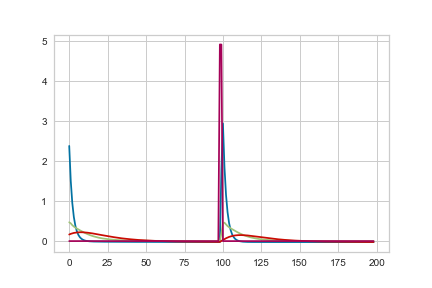

In [9]:
fig, ax = plt.subplots()
ax.plot(fp_data[t_cropping[0]:t_cropping[1], :])

In [10]:
# Write data
print(raw_data)
zda_writer = ZDA_Writer()
zda_writer.write_zda_to_file(raw_data, meta, selected_filename + ".zda", rli, fp_data[t_cropping[0]:t_cropping[1], :])

plt.plot(raw_data[0,:,40,40])

[[[[2032 2181 2050 ... 2168 2329 2312]
   [2263 2109 2117 ... 2300 2212 1926]
   [1807 2079 2031 ... 1842 2394 1840]
   ...
   [1978 2037 2077 ... 2211 2027 2124]
   [2153 2047 2028 ... 1983 2043 2150]
   [2068 2187 1958 ... 2438 2368 2075]]

  [[2140 2108 1838 ... 2072 1874 1695]
   [2160 1968 2010 ... 2221 1835 2104]
   [2186 2134 2273 ... 2504 2409 2017]
   ...
   [2238 1849 2060 ... 2301 2071 1954]
   [2036 1948 2196 ... 2228 1986 2391]
   [2209 2104 1846 ... 2182 1829 2024]]

  [[2062 1933 2338 ... 1710 2214 1724]
   [1922 1726 1783 ... 1705 1801 1963]
   [2268 1938 2008 ... 1817 1339 2171]
   ...
   [1978 2144 2232 ... 1972 2125 1946]
   [2015 1768 1788 ... 1891 1913 1754]
   [1859 1964 2230 ... 1731 1623 1866]]

  ...

  [[1985 2506 1622 ... 2024 2087 2257]
   [2126 2242 2288 ... 2618 2431 2380]
   [2201 2028 2143 ... 1965 2187 2369]
   ...
   [2068 2043 2060 ... 2151 2201 2338]
   [2408 2482 2179 ... 1955 2074 2317]
   [2175 2073 2250 ... 1978 2006 1949]]

  [[2449 2305 2741 ..